In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Loading train_dataframe

In [2]:
test_dir = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test"
train_dir = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
train_df = pd.read_csv('/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
train_df.head(2)

image_id  class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R11    NaN   
1  21a10246a5ec7af151081d0cd6d65dc9  No finding        14     R7    NaN   

   y_min  x_max  y_max  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN

## mapping image_id to its image_path

In [3]:
import glob
from tqdm import tqdm
import pandas as pd

# Enable pandas progress_apply
tqdm.pandas()

# Load the list of training DICOM images
yy = glob.glob(train_dir + "/*")

# Apply progress_apply to create the 'ImagePath' column
train_df['ImagePath'] = train_df['image_id'].progress_apply(lambda x: next(filter(lambda y: x in y, yy), None))

# Filter out the 'No Finding' class (class_id == 14)
train_df = train_df[train_df['class_id'] != 14].reset_index(drop=True)

# Select only required columns
train_df = train_df[['ImagePath', 'image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']]


100%|██████████| 67914/67914 [01:23<00:00, 809.01it/s]


## Analysis of the train_dataframe

In [4]:
print("No Of The Unique ImagePath :--->", len(set(train_df['ImagePath'])))
print("Shape Of The Data Frame :->", train_df.shape)
train_df.head(2)

No Of The Unique ImagePath :---> 4394
Shape Of The Data Frame :-> (36096, 9)


ImagePath  \
0  /kaggle/input/vinbigdata-chest-xray-abnormalit...   
1  /kaggle/input/vinbigdata-chest-xray-abnormalit...   

                           image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   

    x_min   y_min   x_max   y_max  
0   691.0  1375.0  1653.0  1831.0  
1  1264.0   743.0  1611.0  1019.0

### Function To Convert Diacom To An Image
#### Creating Train and Validation Directories and Converting the DICOM to Image Array and  Saving It in Train and Validation Directories

In [5]:
import os
import glob
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import warnings
warnings.filterwarnings("ignore")

In [6]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

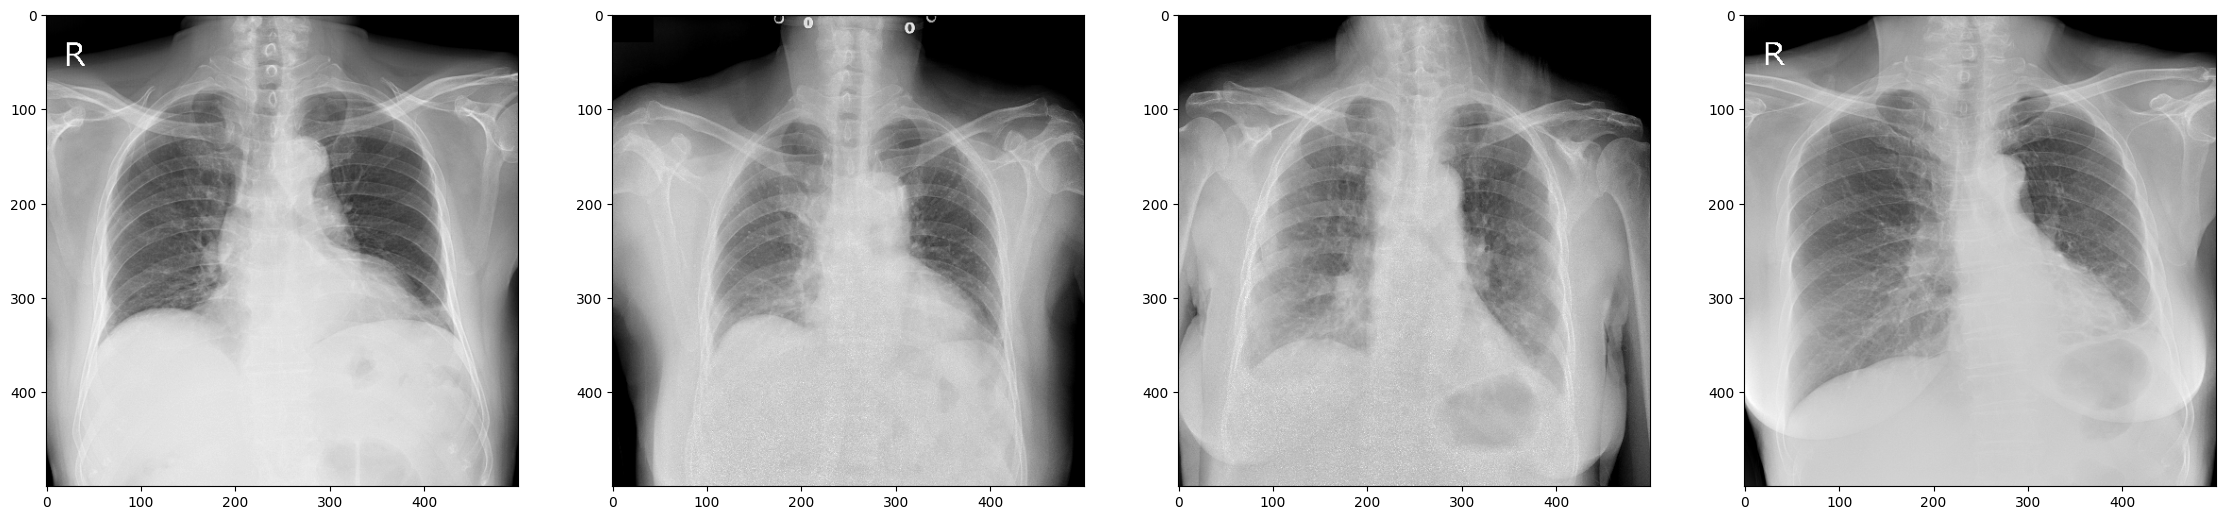

In [7]:
dicom_paths =  list(set(train_df['ImagePath']))
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

### Maybe, you can try some preprocess like equalize histogram. You can see the difference between before and after

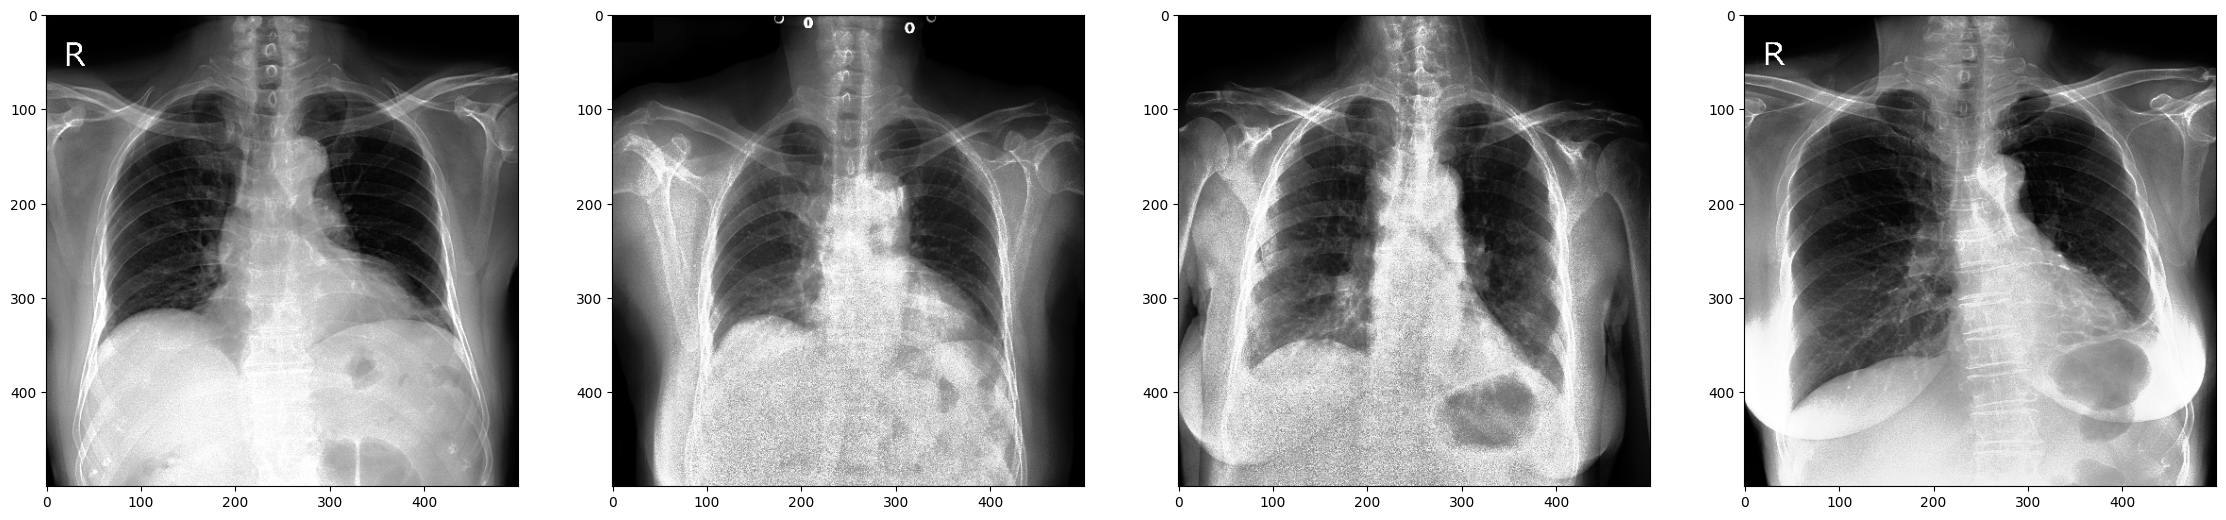

In [8]:
from skimage import exposure
imgs = [exposure.equalize_hist(img) for img in imgs]
plot_imgs(imgs)

## Function to save the image in a slower way

In [9]:
# def saving_image(output_dir, dicom_path_list = dicom_paths):
#     for dicom_path in tqdm(dicom_path_list):
#         file_name = os.path.basename(dicom_path).split('.')[0]
#         image_array = dicom2array(dicom_path)
#         equalized_image = exposure.equalize_hist(image_array)
#         cv2.imwrite(os.path.join(output_dir, f"{file_name}.jpeg"), equalized_image)

# # Example usage:
# output_dir = "/kaggle/working/chest_detection/Images"
# os.makedirs(output_dir, exist_ok=True)

# # Call the function to save images
# saving_image(output_dir, dicom_paths[:3])

### Here we will use MultiThreading to Process and save the image in a faster way 

In [10]:
import os
import cv2
import numpy as np
import pydicom
import multiprocessing
from tqdm import tqdm
from skimage import exposure

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def process_image(dicom_path_output_dir):
    dicom_path, output_dir = dicom_path_output_dir
    file_name = os.path.splitext(os.path.basename(dicom_path))[0]
    image_array = dicom2array(dicom_path)
    equalized_image = exposure.equalize_hist(image_array)
    equalized_image = (equalized_image * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir, f"{file_name}.jpeg"), equalized_image)

def saving_image(output_dir, dicom_path_list):
    os.makedirs(output_dir, exist_ok=True)
    dicom_path_output_dir_list = [(path, output_dir) for path in dicom_path_list]

    # Use multiprocessing Pool for parallel processing
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(process_image, dicom_path_output_dir_list), total=len(dicom_path_list), desc="Processing Images"))

### Now We Will Process The Train Diacom Images

In [11]:
# Example usage:
output_dir = "/kaggle/working/chest_detection/images"
os.makedirs(output_dir, exist_ok=True)

# Call the function to save images
saving_image(output_dir, dicom_paths)

Processing Images: 100%|██████████| 4394/4394 [37:01<00:00,  1.98it/s]


### Now We Will Process The Test Diacom Image

In [12]:
test_dicom_paths = glob.glob("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/*")

In [13]:
# Example usage:
output_dir = "/kaggle/working/chest_detection/test"
os.makedirs(output_dir, exist_ok=True)

# Call the function to save images
saving_image(output_dir, test_dicom_paths)

Processing Images: 100%|██████████| 3000/3000 [22:39<00:00,  2.21it/s]


### now we will visualize the image on the  images directory

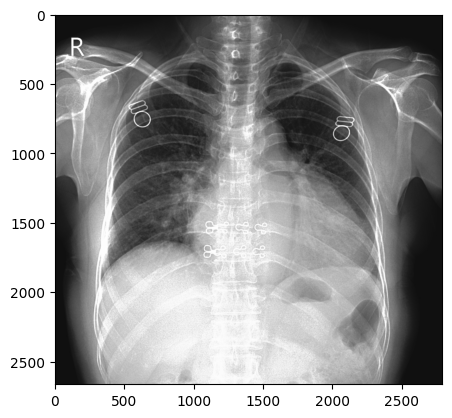

In [14]:
yy = glob.glob("/kaggle/working/chest_detection/images/*") ## SaveImagePath
array = cv2.imread(yy[2])
plt.imshow(array)

### Checking Whether The height and width of all image is same or different
### THis Will Help In Normalizing BoudingBox

In [15]:
heights = []
widths =  []

# Use list comprehensions for a more concise and efficient code
heights = [cv2.imread(i).shape[0] for i in tqdm(yy)]
widths = [cv2.imread(i).shape[1] for i in tqdm(yy)]

100%|██████████| 4394/4394 [04:59<00:00, 14.67it/s]


In [16]:
print("Height is ", heights[:3])
print("width is ", widths[:3])

### As We Can Clearly See That The Height And Width Vary From Image To Image.

Height is  [2880, 1944, 2664]
width is  [2304, 1872, 2792]


### Creating Dataframe which will contain the columns SaveImagePath , heights and width

In [17]:
### Now Creating Data Frame For The Height ,Width 
df = pd.DataFrame(yy, columns =['SaveImagePath'])
df['image_id'] = df['SaveImagePath'].apply(lambda x: x.split('/')[-1].split('.')[0])
df['Height'] = heights
df['Width']  = widths
print("shape Of The Data Frame :->", df.shape)
df.head(1)

print("shape of the train_df", train_df.shape)

shape Of The Data Frame :-> (4394, 4)
shape of the train_df (36096, 9)


In [18]:
final_df  = train_df.merge(df, on = 'image_id')
final_df.head(2)

ImagePath  \
0  /kaggle/input/vinbigdata-chest-xray-abnormalit...   
1  /kaggle/input/vinbigdata-chest-xray-abnormalit...   

                           image_id          class_name  class_id rad_id  \
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   

    x_min   y_min   x_max   y_max  \
0   691.0  1375.0  1653.0  1831.0   
1  1264.0   743.0  1611.0  1019.0   

                                       SaveImagePath  Height  Width  
0  /kaggle/working/chest_detection/images/9a5094b...    2336   2080  
1  /kaggle/working/chest_detection/images/051132a...    2880   2304

## Converting DataFrame to YOLO Format:

#### To prepare bounding box annotations for YOLO object detection, the DataFrame containing bounding box coordinates and class labels needs to be converted to YOLO format. 

In YOLO format, bounding box coordinates are normalized to the range [0, 1], where (x_center, y_center, width, height) are relative to the image dimensions. This normalized format ensures consistency across images of different sizes and aspect ratios.


In [19]:
def convert_to_yolo_format(df):
    # Normalize the bounding box coordinates
    df['center_x'] = (df['x_min'] + df['x_max']) / 2
    df['center_y'] = (df['y_min'] + df['y_max']) / 2
    df['b_box_width'] = df['x_max'] - df['x_min']
    df['b_box_height'] = df['y_max'] - df['y_min']
    
    # Calculate normalized coordinates and dimensions
    df['normalized_x'] = df['center_x'] / df['Width']
    df['normalized_y'] = df['center_y'] / df['Height']
    df['normalized_width'] = df['b_box_width'] / df['Width']
    df['normalized_height'] = df['b_box_height'] / df['Height']
    
    return df

### This Function Will Return The DataFrame With Normalize Bounding Box
df_yolo = convert_to_yolo_format(final_df)

In [20]:
df_yolo.head(1)

ImagePath  \
0  /kaggle/input/vinbigdata-chest-xray-abnormalit...   

                           image_id    class_name  class_id rad_id  x_min  \
0  9a5094b2563a1ef3ff50dc5c7ff71345  Cardiomegaly         3    R10  691.0   

    y_min   x_max   y_max                                      SaveImagePath  \
0  1375.0  1653.0  1831.0  /kaggle/working/chest_detection/images/9a5094b...   

   Height  Width  center_x  center_y  b_box_width  b_box_height  normalized_x  \
0    2336   2080    1172.0    1603.0        962.0         456.0      0.563462   

   normalized_y  normalized_width  normalized_height  
0      0.686216            0.4625           0.195205

### Function To Save The Bounding Box

In [21]:
def Get_Bounding_Box(df, output_file):
    # Open the output file for writing
    with open(output_file, 'w') as f:
        # Iterate over the filtered DataFrame and write bounding box information to the file
        for _, row in df.iterrows():
            class_id = row['class_id']
            x_center, y_center = row['normalized_x'], row['normalized_y']
            width, height = row["normalized_width"], row['normalized_height']
#             print(f"{class_id}\t{x_center}\t{y_center}\t{width}\t{height}\n")
            f.write(f"{class_id}\t{x_center}\t{y_center}\t{width}\t{height}\n")

# Example usage:
Get_Bounding_Box(df=df_yolo, output_file='test.txt')

Image_label_dir = "/kaggle/working/chest_detection/labels"
os.makedirs(Image_label_dir, exist_ok = True)

print("Storing  Training Image BoundingBox","-"*50)
print("Train label dir is ", Image_label_dir)
for file in tqdm(yy):
    filename = file.split('/')[-1].split('.')[0]
    Get_Bounding_Box(df=df_yolo.head(), output_file = Image_label_dir+"/"+filename+".txt")


Storing  Training Image BoundingBox --------------------------------------------------
Train label dir is  /kaggle/working/chest_detection/labels


100%|██████████| 4394/4394 [00:03<00:00, 1455.72it/s]


### Conclusion :- > Finally  We Have store Images and Label in Chest Directory

#### Lets Check Inside the label directory


In [22]:
label_files = glob.glob('/kaggle/working/chest_detection/labels/*')
'/kaggle/working/chest_detection/Images/5184bc9a54adf7c8cb707c45f21fd741.jpeg'

with open(label_files[0]) as f:
    file = f.read()
    print(file)

3	0.5634615384615385	0.6862157534246576	0.4625	0.1952054794520548
0	0.6239149305555556	0.3059027777777778	0.1506076388888889	0.09583333333333334
11	0.3098425196850394	0.12858072916666666	0.12598425196850394	0.024739583333333332
5	0.7735229759299781	0.47240704500978475	0.36805251641137854	0.7530332681017613
8	0.2398753894080997	0.7211452430659111	0.045950155763239874	0.0393677303906949



## Lets Check Inside the Image directory

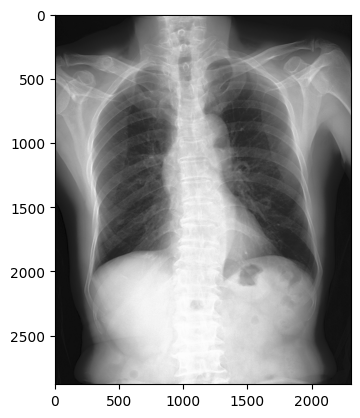

In [23]:
image_files = yy[0]

array = cv2.imread(image_files)
plt.imshow(array)

## Bounding Box

Function: plot_bounding_boxes_on_image

Description:
This function plots bounding boxes on top of an image using the provided bounding box labels and class dictionary.

Parameters:

image_path: Path to the image file.
bounding_box_label_path: Path to the file containing bounding box labels.
class_dict: Dictionary mapping class IDs to class labels. Defaults to an empty dictionary.

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_image_with_bounding_box(image, bounding_boxes, class_dict):
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    for box in bounding_boxes:
        class_id, x, y, width, height = map(float, box.split())
        image_width, image_height = image.shape[1], image.shape[0]
        x1 = int((x - width / 2) * image_width)
        y1 = int((y - height / 2) * image_height)
        x2 = int((x + width / 2) * image_width)
        y2 = int((y + height / 2) * image_height)
        
        # Choose random color for bounding box
        color = [random.random() for _ in range(3)]
        
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label text using class label from dictionary
        label_text = class_dict[int(class_id)]
        ax.text(x1, y1, label_text, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})
    
    plt.show()

def main(image_path, bounding_box_path, class_dict):
    # Read image
    image = cv2.imread(image_path)
    
    # Read bounding boxes
    with open(bounding_box_path, 'r') as file:
        bounding_boxes = file.readlines()
    
    # Plot image with bounding boxes
    plot_image_with_bounding_box(image, bounding_boxes, class_dict)

In [25]:
yy[0], label_files[0]

('/kaggle/working/chest_detection/images/6a226af290752e9d60405e5a5a18e90f.jpeg',
 '/kaggle/working/chest_detection/labels/569f16cfa1a0c9536565c78b092d098b.txt')

In [26]:
dict_ = dict(zip(df_yolo['class_id'], df_yolo['class_name']))
print(dict_)

{3: 'Cardiomegaly', 0: 'Aortic enlargement', 11: 'Pleural thickening', 5: 'ILD', 8: 'Nodule/Mass', 13: 'Pulmonary fibrosis', 7: 'Lung Opacity', 1: 'Atelectasis', 9: 'Other lesion', 6: 'Infiltration', 10: 'Pleural effusion', 2: 'Calcification', 4: 'Consolidation', 12: 'Pneumothorax'}


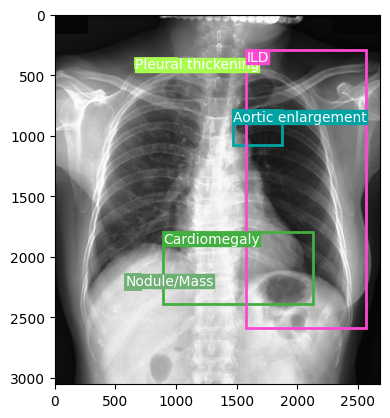

In [27]:
img_no = 44
main(yy[img_no], label_files[img_no], class_dict = dict_)

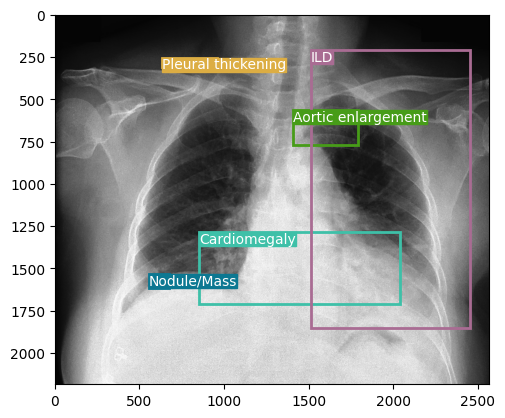

In [28]:
img_no = 45
main(yy[img_no], label_files[img_no], class_dict = dict_)

##### In the Second Part, We Will Perform Image Analysis and Download All the Images and Text Files¶

## PART--2) .  YOLO-IMPLEMENTATION:--------

In [29]:
label_files[0], yy[0]

('/kaggle/working/chest_detection/labels/569f16cfa1a0c9536565c78b092d098b.txt',
 '/kaggle/working/chest_detection/images/6a226af290752e9d60405e5a5a18e90f.jpeg')

##  correct label_text_files, and Image_files

In [30]:
print("first 3 label_files :->", label_files[:3])

image_files = []
for label in label_files:
    label_name = label.split('/')[-1].split('.')[0]
    image_files.extend([i for i in yy if label_name in i])
    
print("-"*90)
print("first 3 image_files", image_files[:3])
    

first 3 label_files :-> ['/kaggle/working/chest_detection/labels/569f16cfa1a0c9536565c78b092d098b.txt', '/kaggle/working/chest_detection/labels/3ce8e5fe27fc9db53129cdbdd8de89de.txt', '/kaggle/working/chest_detection/labels/6bb053f269fb54485e70eb65424578f3.txt']
------------------------------------------------------------------------------------------
first 3 image_files ['/kaggle/working/chest_detection/images/569f16cfa1a0c9536565c78b092d098b.jpeg', '/kaggle/working/chest_detection/images/3ce8e5fe27fc9db53129cdbdd8de89de.jpeg', '/kaggle/working/chest_detection/images/6bb053f269fb54485e70eb65424578f3.jpeg']


In [31]:
df = pd.DataFrame(list(zip(label_files, image_files)), columns=['label_files', 'image_files'])
print(df.shape)
df.head(2)

## Now We have correct the label of the image files and label files 

(4394, 2)


label_files  \
0  /kaggle/working/chest_detection/labels/569f16c...   
1  /kaggle/working/chest_detection/labels/3ce8e5f...   

                                         image_files  
0  /kaggle/working/chest_detection/images/569f16c...  
1  /kaggle/working/chest_detection/images/3ce8e5f...

THis df Is The Actual train_data , Now from  this we will create train(90%) and valid(10%)

In [32]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size = 19 , random_state = 42)
print("shape of df_train", df_train.shape)
print("shape of df_valid", df_valid.shape)

shape of df_train (4375, 2)
shape of df_valid (19, 2)


## Cloning Yolo V9 From Github

In [33]:
import os
HOME = "/kaggle/working/"  ## Get The Current Working Directory 
print(HOME)
os.chdir(HOME)

## Git Clone Yolo V9 

!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

/kaggle/working/
Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 2.25 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/kaggle/working/yolov9


### Downloading Model Weights 

In [34]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

## Now We Will Create dataset folder 

In [35]:
cwd = "/kaggle/working/"
data_train_images = cwd+"data/train/images"
data_train_labels = cwd+"data/train/labels"

data_valid_images = cwd+"data/valid/images"
data_valid_labels = cwd+"data/valid/labels/"

os.makedirs(data_train_images, exist_ok = True)
os.makedirs(data_train_labels, exist_ok = True)

os.makedirs(data_valid_images, exist_ok = True)
os.makedirs(data_valid_labels, exist_ok = True)

In [36]:
df_valid.head(1)

label_files  \
3252  /kaggle/working/chest_detection/labels/333a307...   

                                            image_files  
3252  /kaggle/working/chest_detection/images/333a307...

 Now We have Created data folder

#### creating dataset folder which will  contain all images and the label  i.e train , valid

In [37]:
import os
import shutil

# Creating directories for train and validation images and labels
os.makedirs("/kaggle/working/dataset/train/images", exist_ok=True)
os.makedirs("/kaggle/working/dataset/valid/images", exist_ok=True)
os.makedirs("/kaggle/working/dataset/train/labels", exist_ok=True)
os.makedirs("/kaggle/working/dataset/valid/labels", exist_ok=True)

# Copying train images
print("COPYING TRAIN IMAGES :-->", "-"*50)
for img_path in df_train['image_files']:
    shutil.move(img_path, "/kaggle/working/dataset/train/images")

# Copying validation images
print("COPYING VALID IMAGES :-->", "-"*50)
for img_path in df_valid['image_files']:
    shutil.move(img_path, "/kaggle/working/dataset/valid/images")

# Copying train labels
print("COPYING TRAIN LABELS :-->", "-"*50)
for label_path in df_train['label_files']:
    shutil.move(label_path, "/kaggle/working/dataset/train/labels")

# Copying validation labels
print("COPYING VALID LABELS :-->", "-"*50)
for label_path in df_valid['label_files']:
    shutil.move(label_path, "/kaggle/working/dataset/valid/labels")


COPYING TRAIN IMAGES :--> --------------------------------------------------
COPYING VALID IMAGES :--> --------------------------------------------------
COPYING TRAIN LABELS :--> --------------------------------------------------
COPYING VALID LABELS :--> --------------------------------------------------


In [38]:
# Counting the number of train labels
train_label_count = len(glob.glob('/kaggle/working/dataset/train/labels/*'))
print("Number of train labels:", train_label_count)

# Counting the number of train images
train_image_count = len(glob.glob('/kaggle/working/dataset/train/images/*'))
print("Number of train images:", train_image_count)

# Counting the number of valid labels
valid_label_count = len(glob.glob('/kaggle/working/dataset/valid/labels/*'))
print("Number of valid labels:", valid_label_count)

# Counting the number of valid images
valid_image_count = len(glob.glob('/kaggle/working/dataset/valid/images/*'))
print("Number of valid images:", valid_image_count)

Number of train labels: 4375
Number of train images: 4375
Number of valid labels: 19
Number of valid images: 19


In [39]:
## Deleting chest_detection 
! rm -rf /kaggle/working/chest_detection

## Moove Our dataset Folder  to Yolo Folder

In [40]:
! rm -rf /kaggle/working/yolov9/dataset

In [41]:
import shutil

# Move the dataset folder to the Yolo folder
dataset_dir = "/kaggle/working/dataset"
yolo_dir = "/kaggle/working/yolov9"
shutil.move(dataset_dir, yolo_dir)

'/kaggle/working/yolov9/dataset'

## Modify Yaml Code  :----->

In [42]:
list(dict_.values())

['Cardiomegaly',
 'Aortic enlargement',
 'Pleural thickening',
 'ILD',
 'Nodule/Mass',
 'Pulmonary fibrosis',
 'Lung Opacity',
 'Atelectasis',
 'Other lesion',
 'Infiltration',
 'Pleural effusion',
 'Calcification',
 'Consolidation',
 'Pneumothorax']

In [43]:
yaml_dir = "/kaggle/working/yolov9/dataset"
print("Yaml Directory Is :--->", yaml_dir)
import yaml

# Data to write to YAML file
data = {
    'names': list(dict_.values()),
    'nc': len(list(dict_.values())),

    'train': 'dataset/train/images/',
    'val': 'dataset/valid/images/'
}

# Write data to YAML file
with open(yaml_dir+'/data.yaml', 'w') as file:
    yaml.dump(data, file)

Yaml Directory Is :---> /kaggle/working/yolov9/dataset


In [44]:
# with open(glob.glob('/kaggle/working/yolov9/dataset/train/labels/*')[0]) as f:
#     file = f.read()
#     print(file)

In [45]:
# glob.glob("/kaggle/working/yolov9/dataset/train/images/*")

## Training Custom Model 

In [46]:
%cd /kaggle/working/yolov9

!python train.py \
--batch 16 --epochs 30 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data /kaggle/working/yolov9/dataset/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/kaggle/working/yolov9
2024-04-07 17:09:16.558773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:09:16.558896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:09:16.697425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/kaggle/working//weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/kaggle/working/yolov9/dataset/data.yaml, hyp=hyp.scrat

## Examine The Training Result:-->

In [47]:
!ls {HOME}/yolov9/runs/train/exp/

F1_curve.png					   opt.yaml
PR_curve.png					   results.csv
P_curve.png					   results.png
R_curve.png					   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1712509796.a09930265114.103.0  train_batch2.jpg
hyp.yaml					   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
labels_correlogram.jpg				   weights


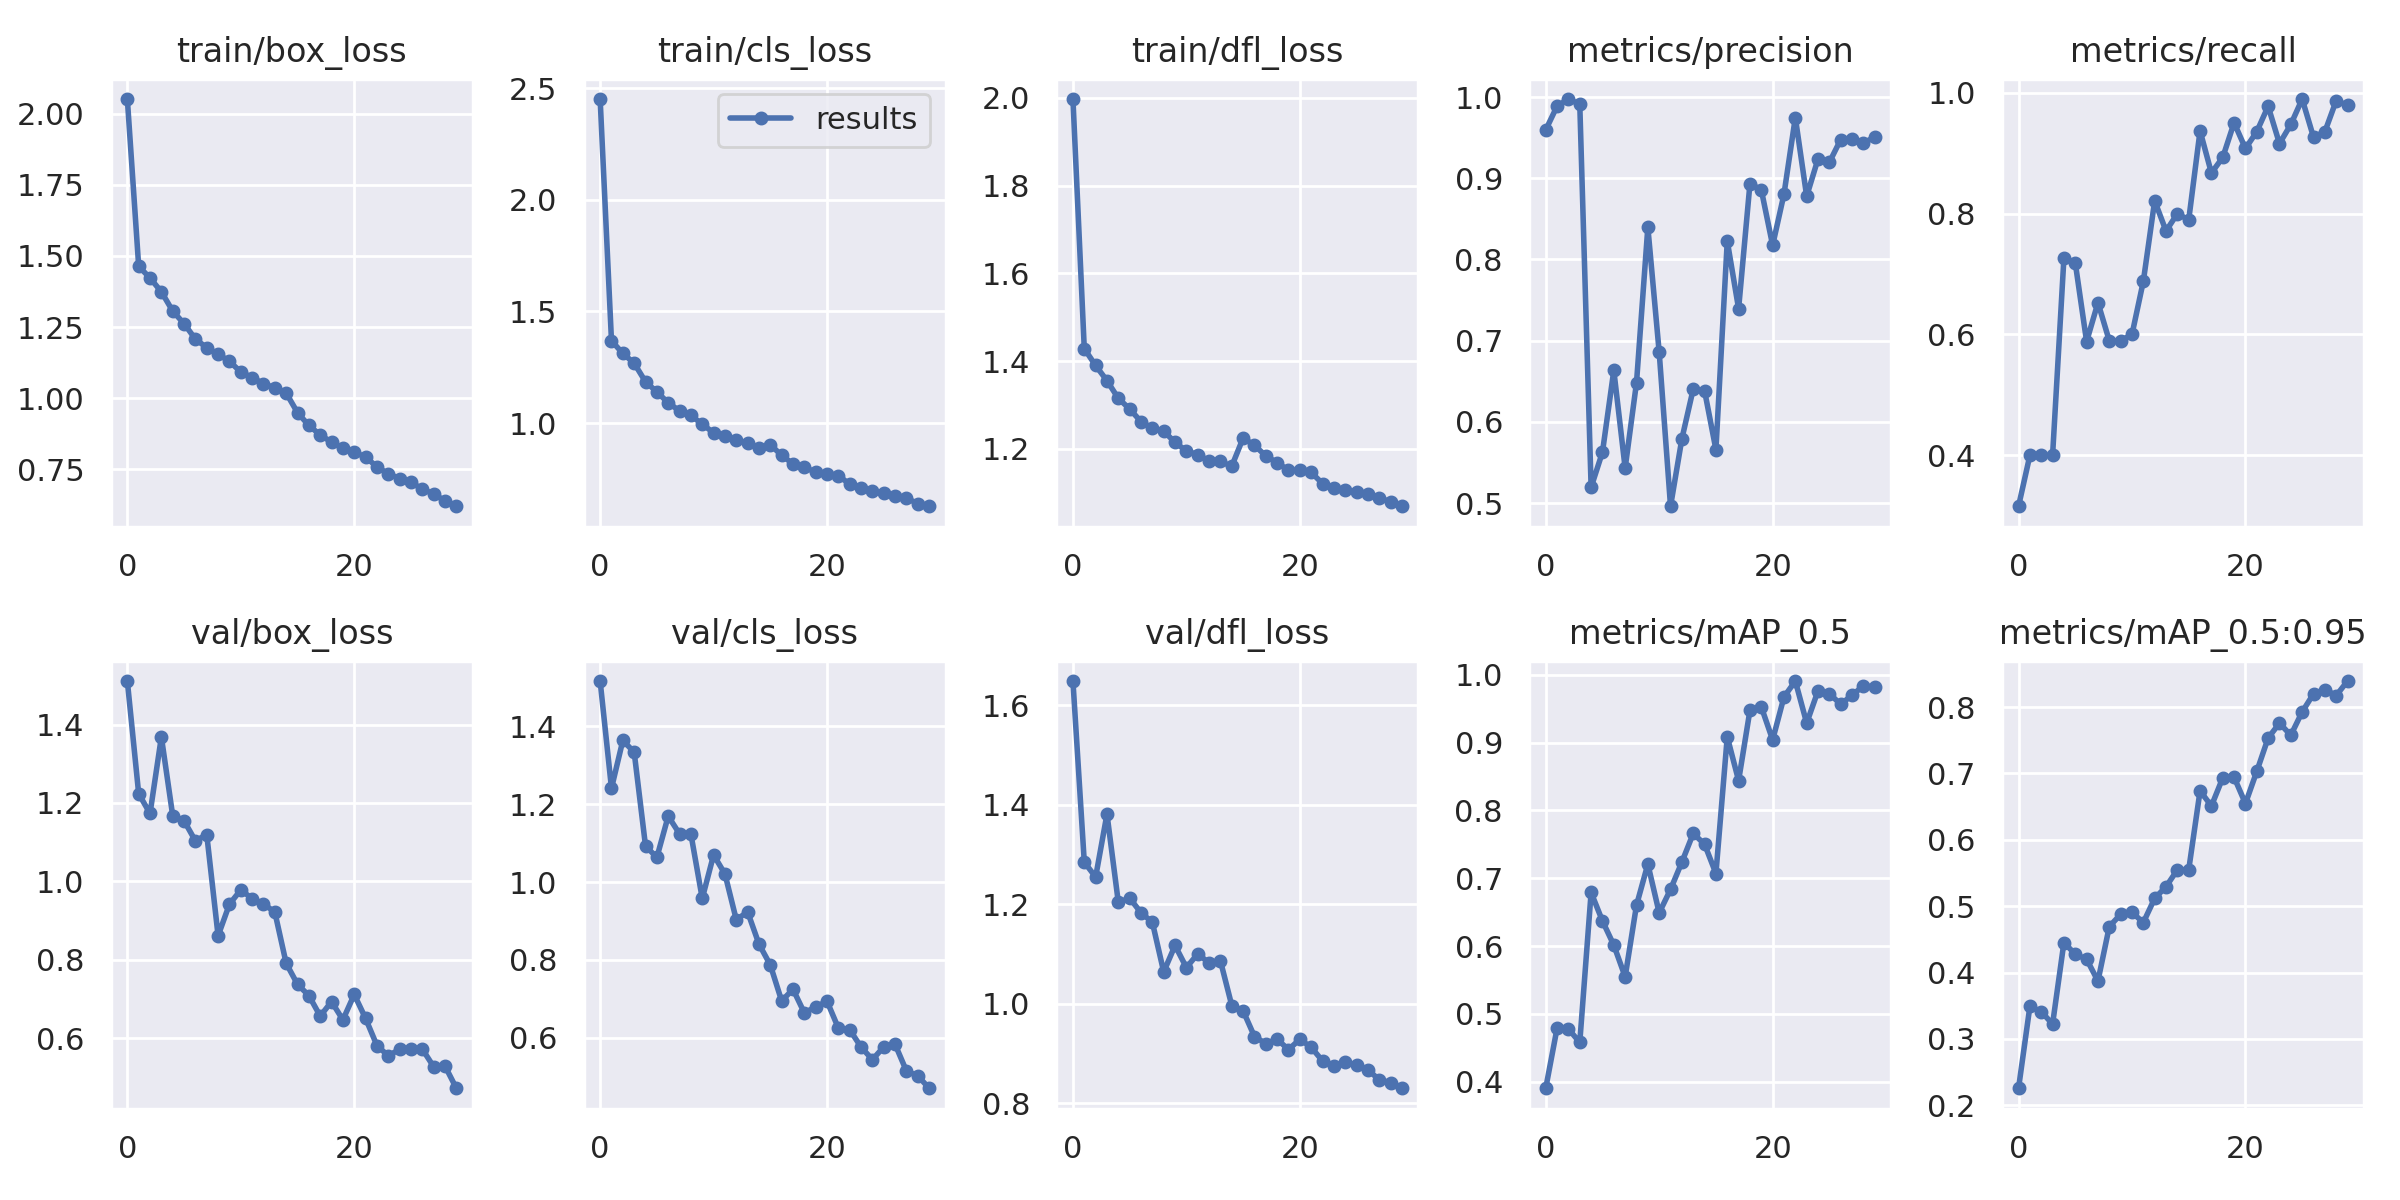

In [48]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=700)

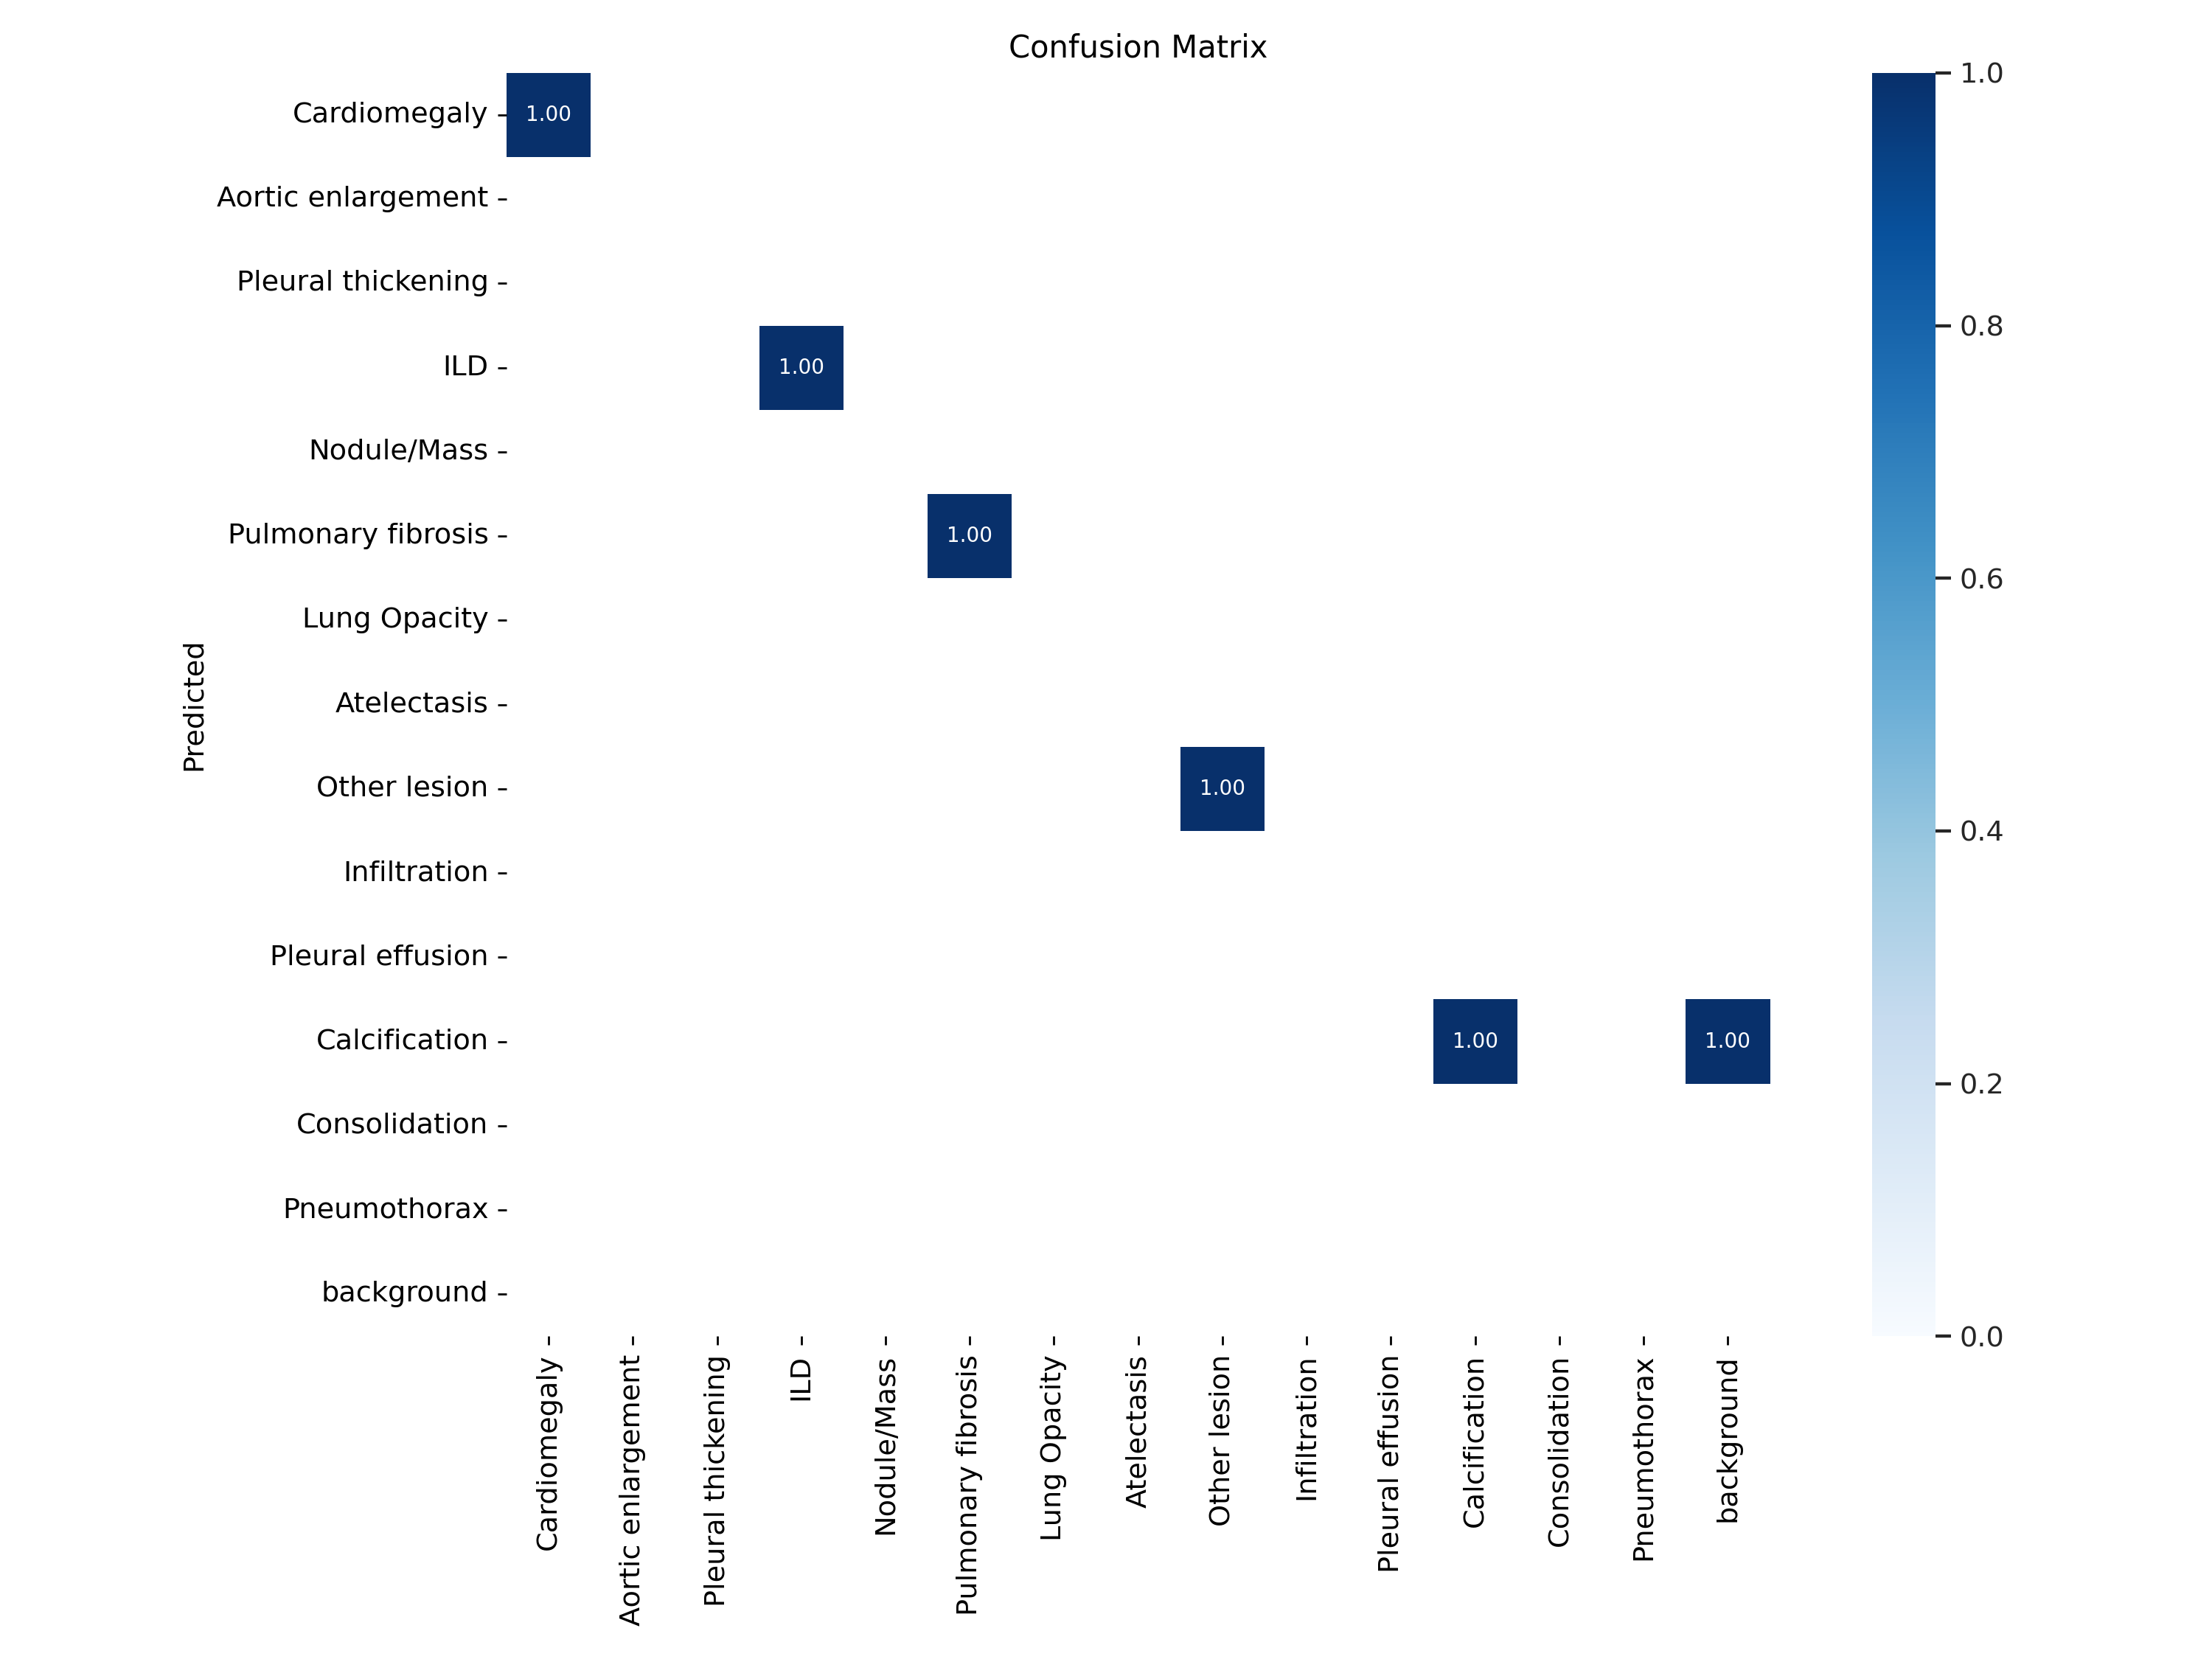

In [49]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

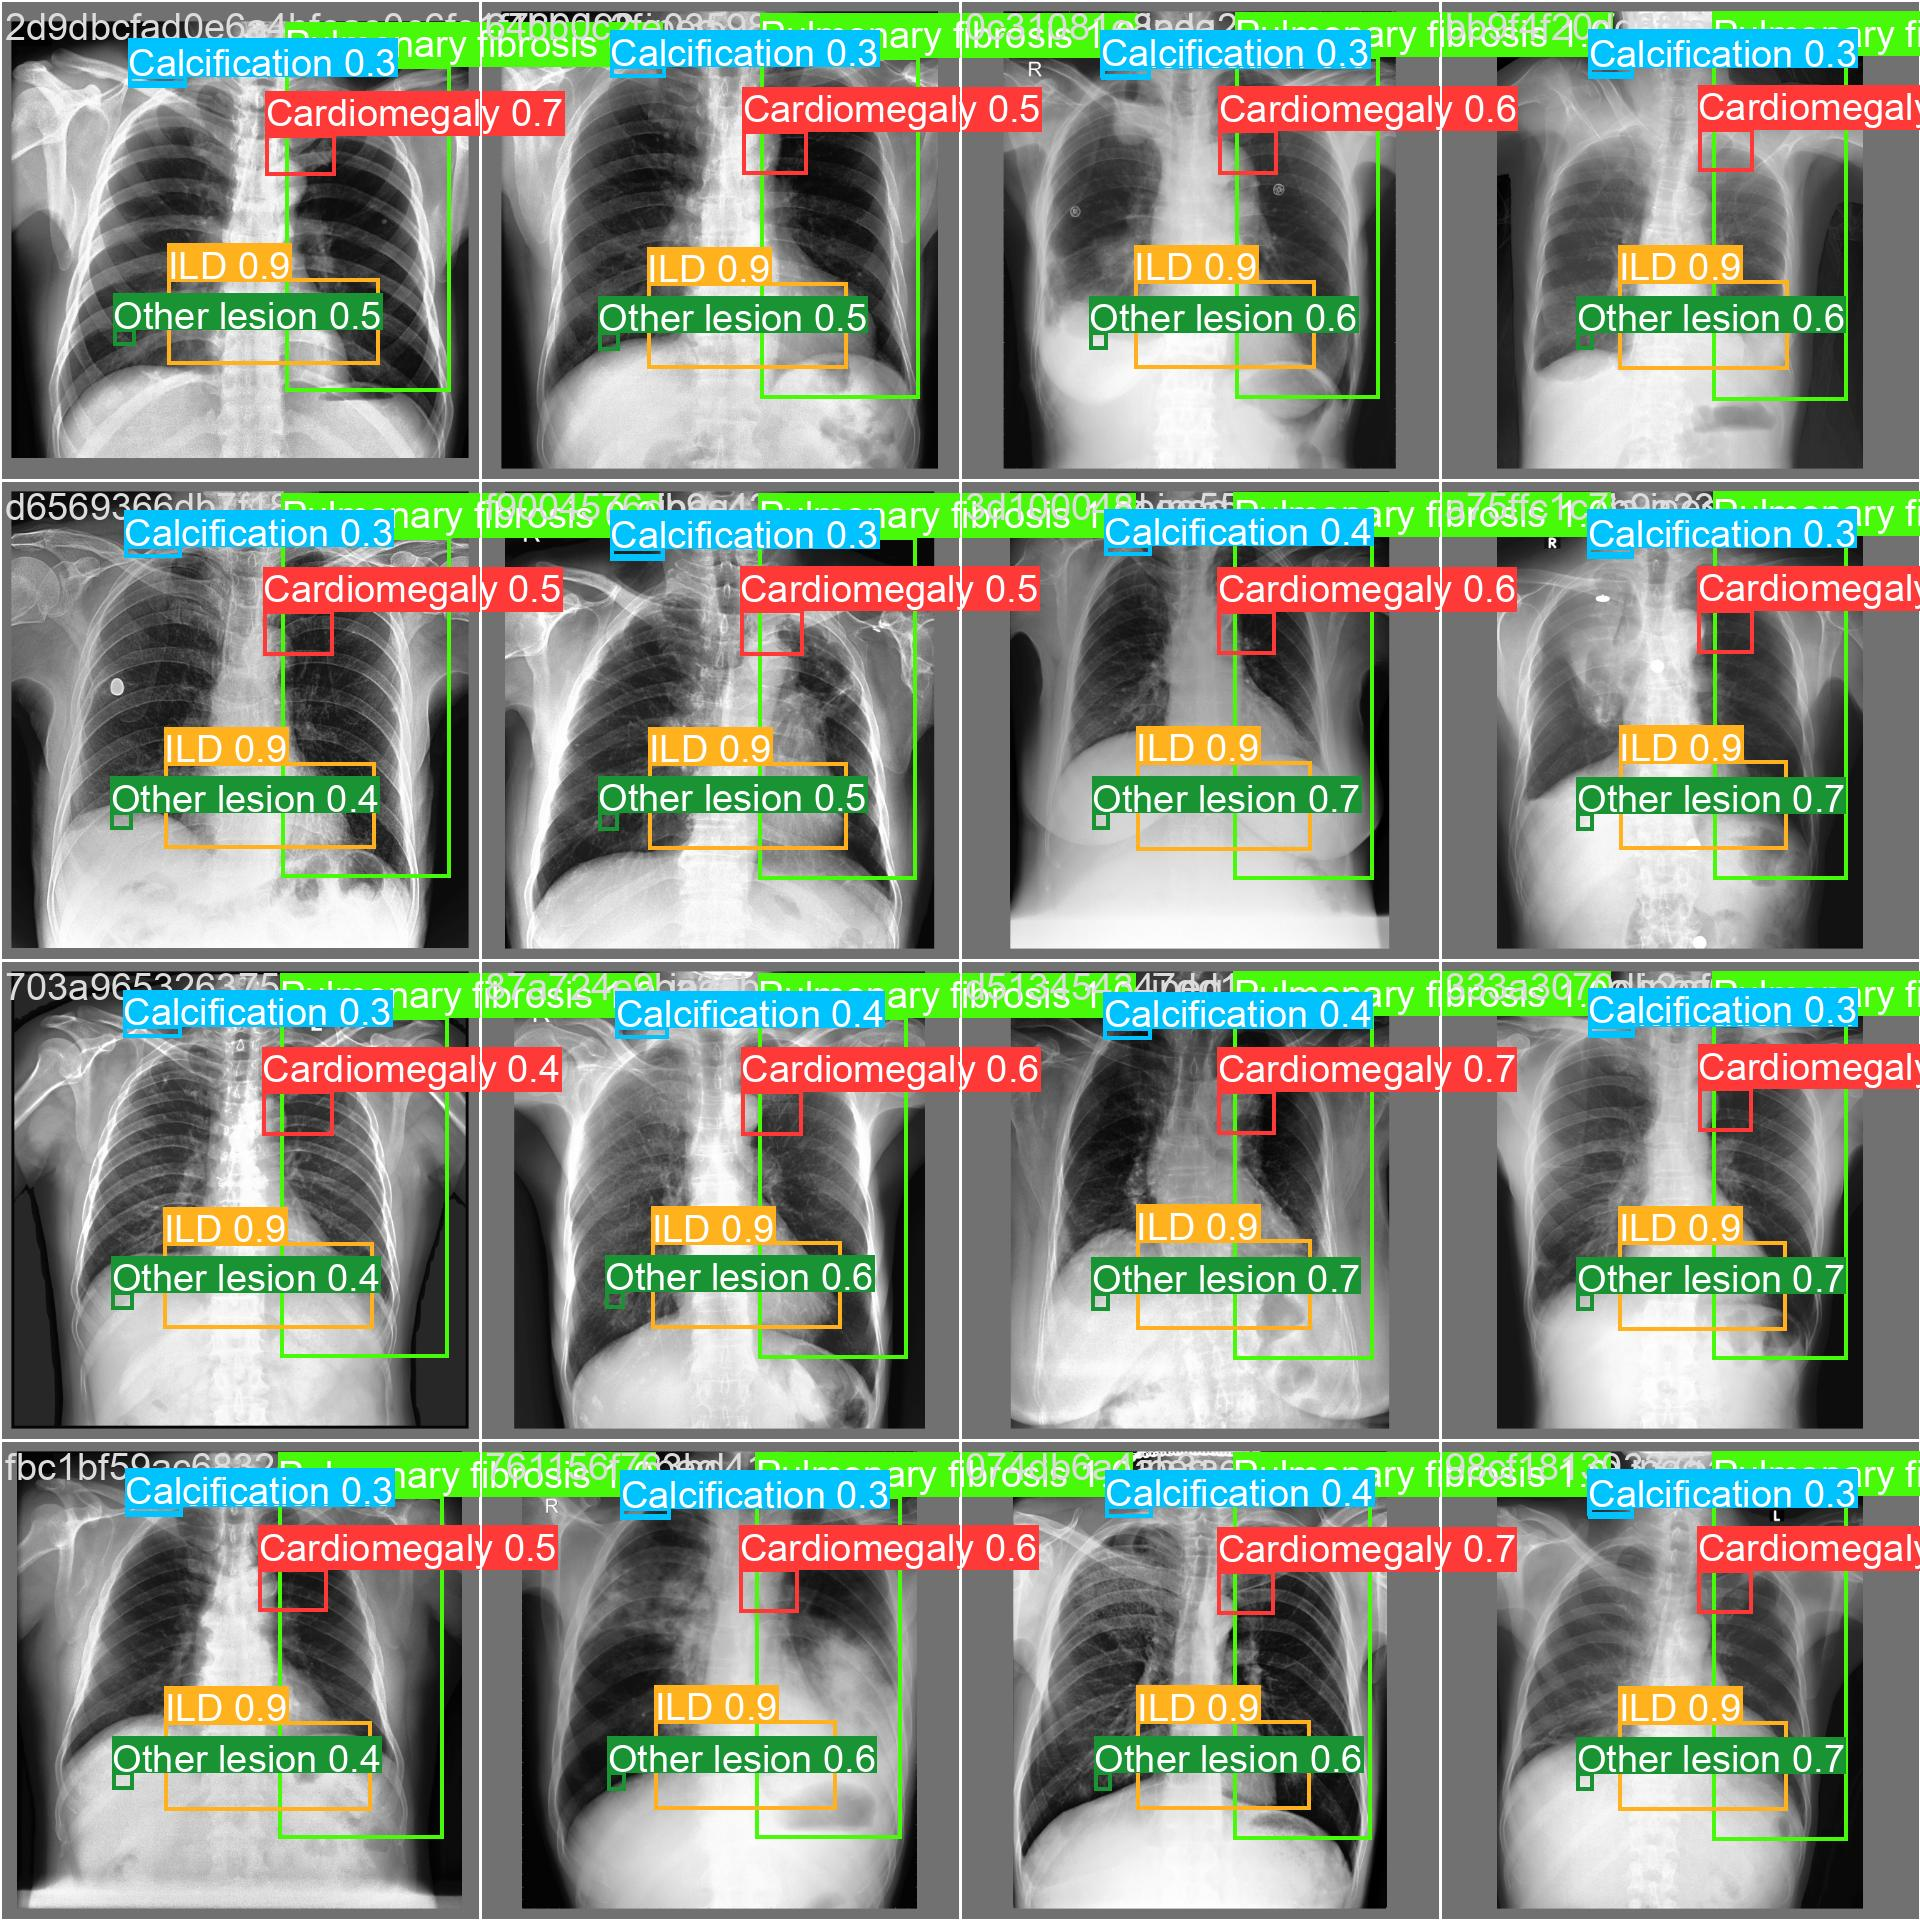

In [50]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

### Now We Will Validate Our Custom Model :--->

In [51]:
%cd /kaggle/working/yolov9


!python val.py \
--img 640 --batch 8 --conf 0.001 --iou 0.7 --device 0 \
--data /kaggle/working/yolov9/dataset/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/kaggle/working/yolov9
val: data=/kaggle/working/yolov9/dataset/data.yaml, weights=['/kaggle/working//yolov9/runs/train/exp/weights/best.pt'], batch_size=8, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25421754 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /kaggle/working/yolov9/dataset/valid/labels.cache... 19 images, 0 
                 Class     Images  Instances          P          R      mAP50   
                   all         19         95      0.963      0.979      0.991      0.832
          Cardiomegaly         19         19      0.981          1      0.995      0.877
                   ILD         19         19        

### With Custom Model 

Here we will give the test data image path 

In [52]:
glob.glob("runs/val/*")

['runs/val/exp']

### Examine the validation data 

In [53]:
!ls {HOME}/yolov9/runs/val/exp/

F1_curve.png  confusion_matrix.png   val_batch1_pred.jpg
PR_curve.png  val_batch0_labels.jpg  val_batch2_labels.jpg
P_curve.png   val_batch0_pred.jpg    val_batch2_pred.jpg
R_curve.png   val_batch1_labels.jpg


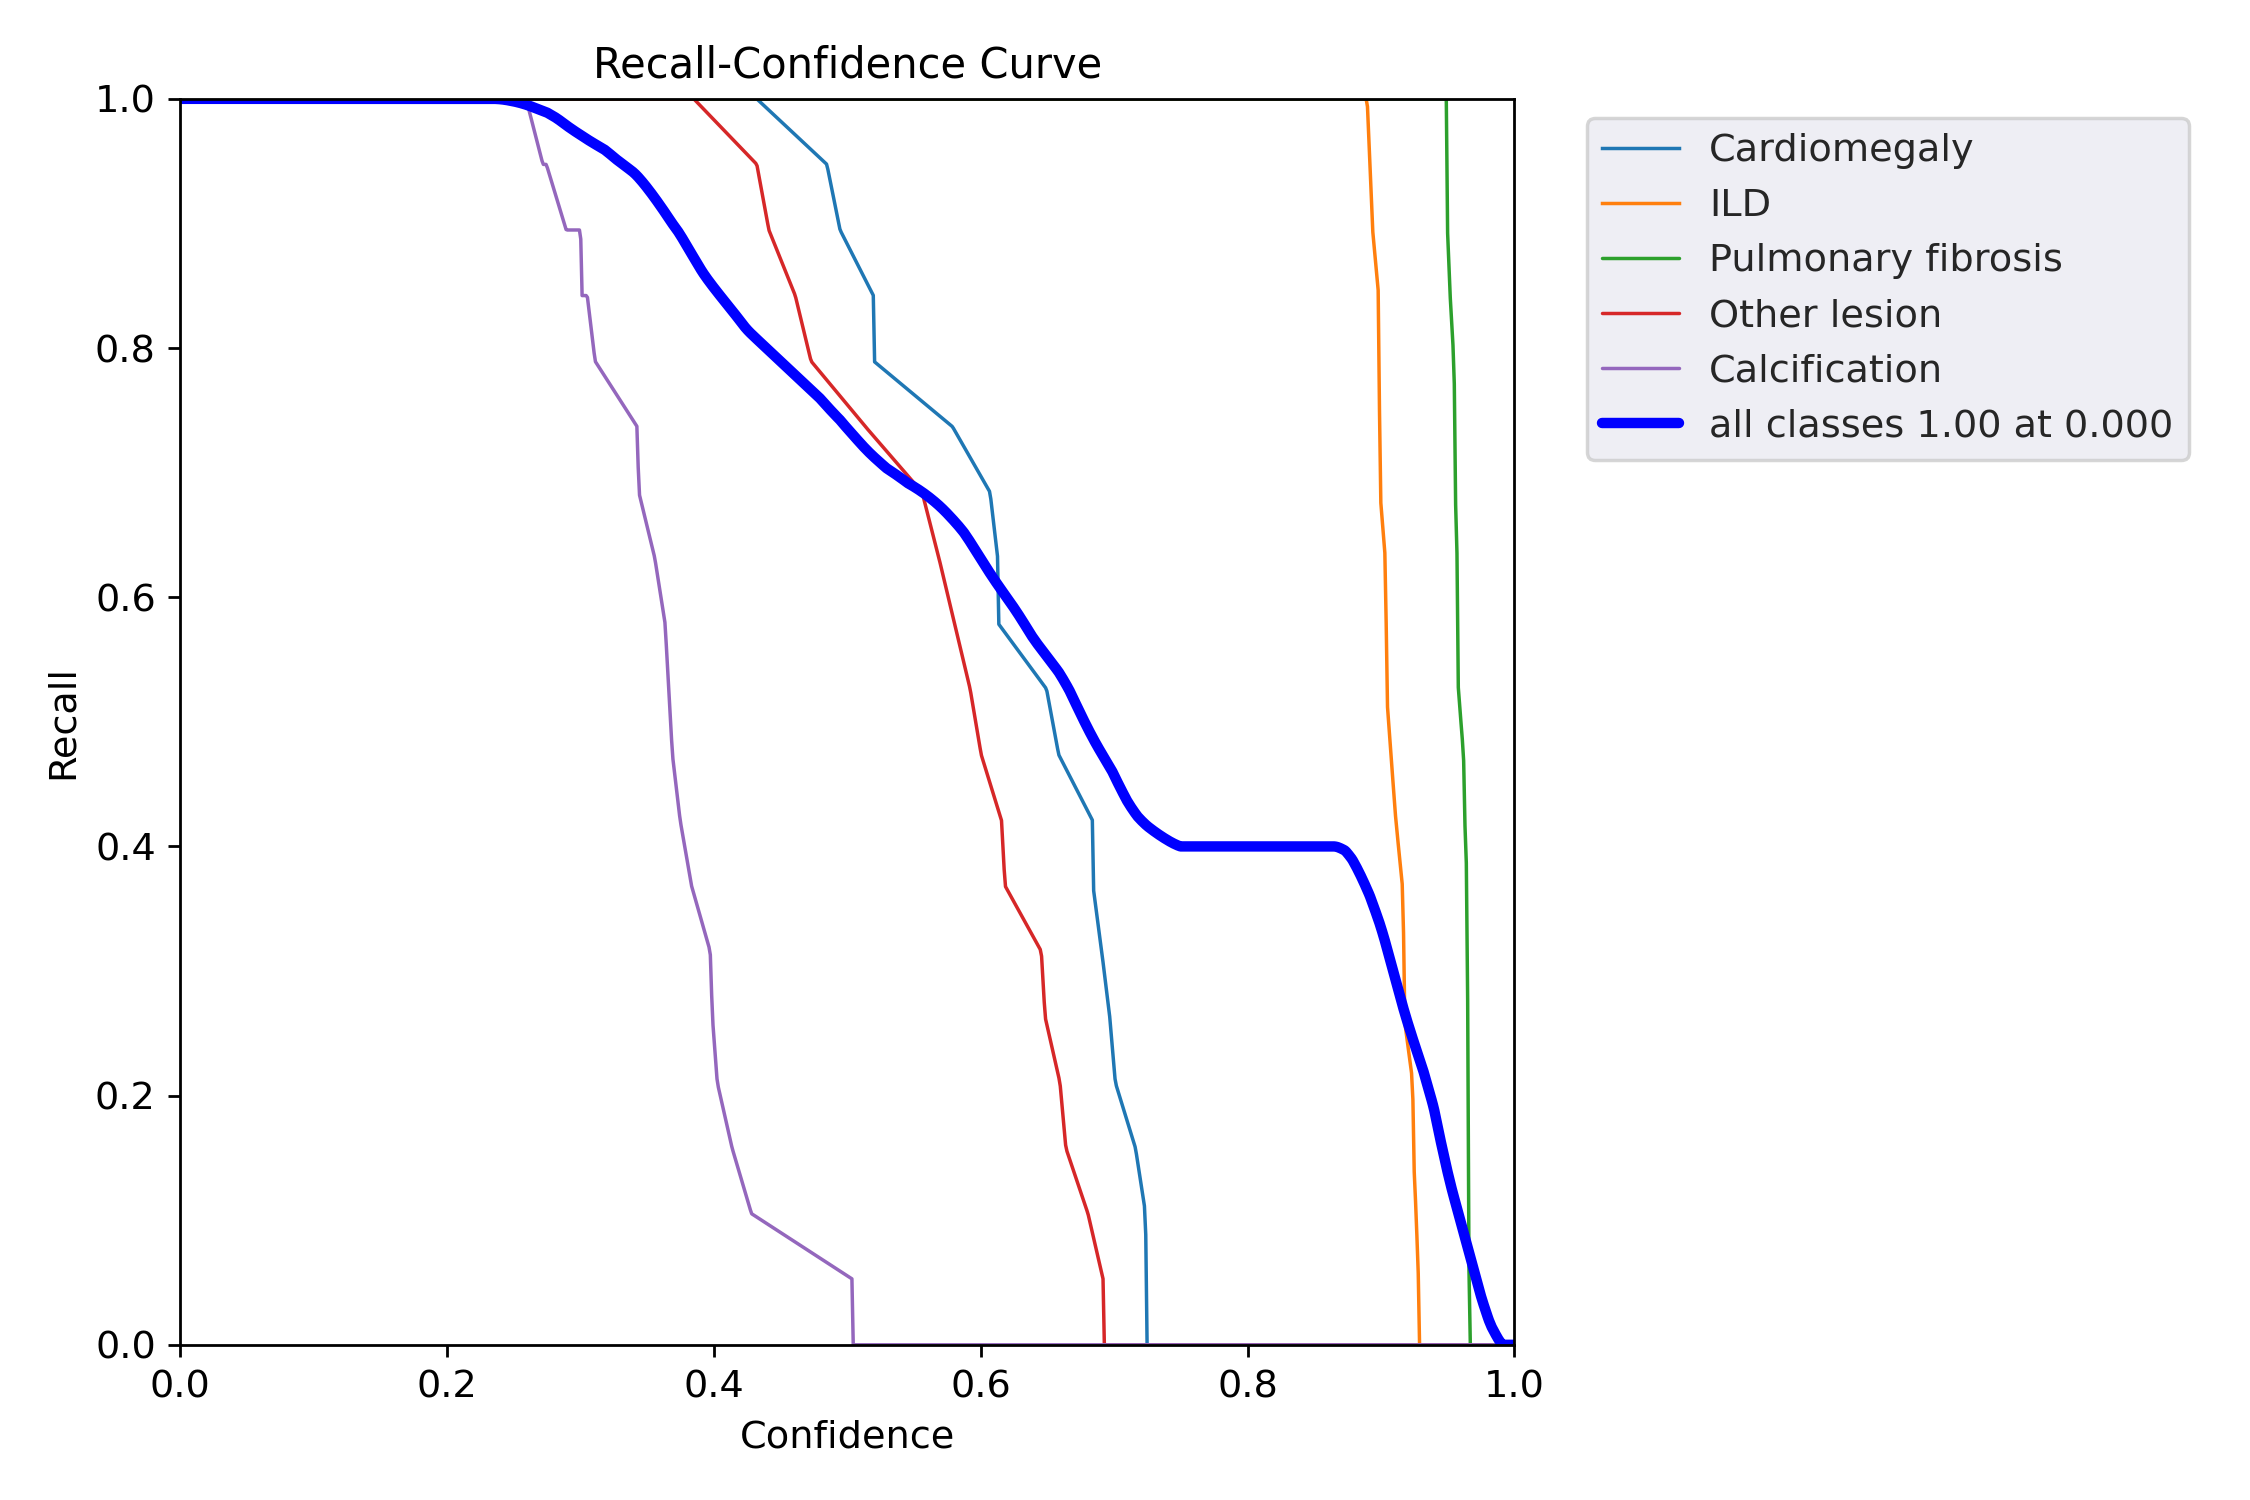

In [54]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/val/exp/R_curve.png", width=700)

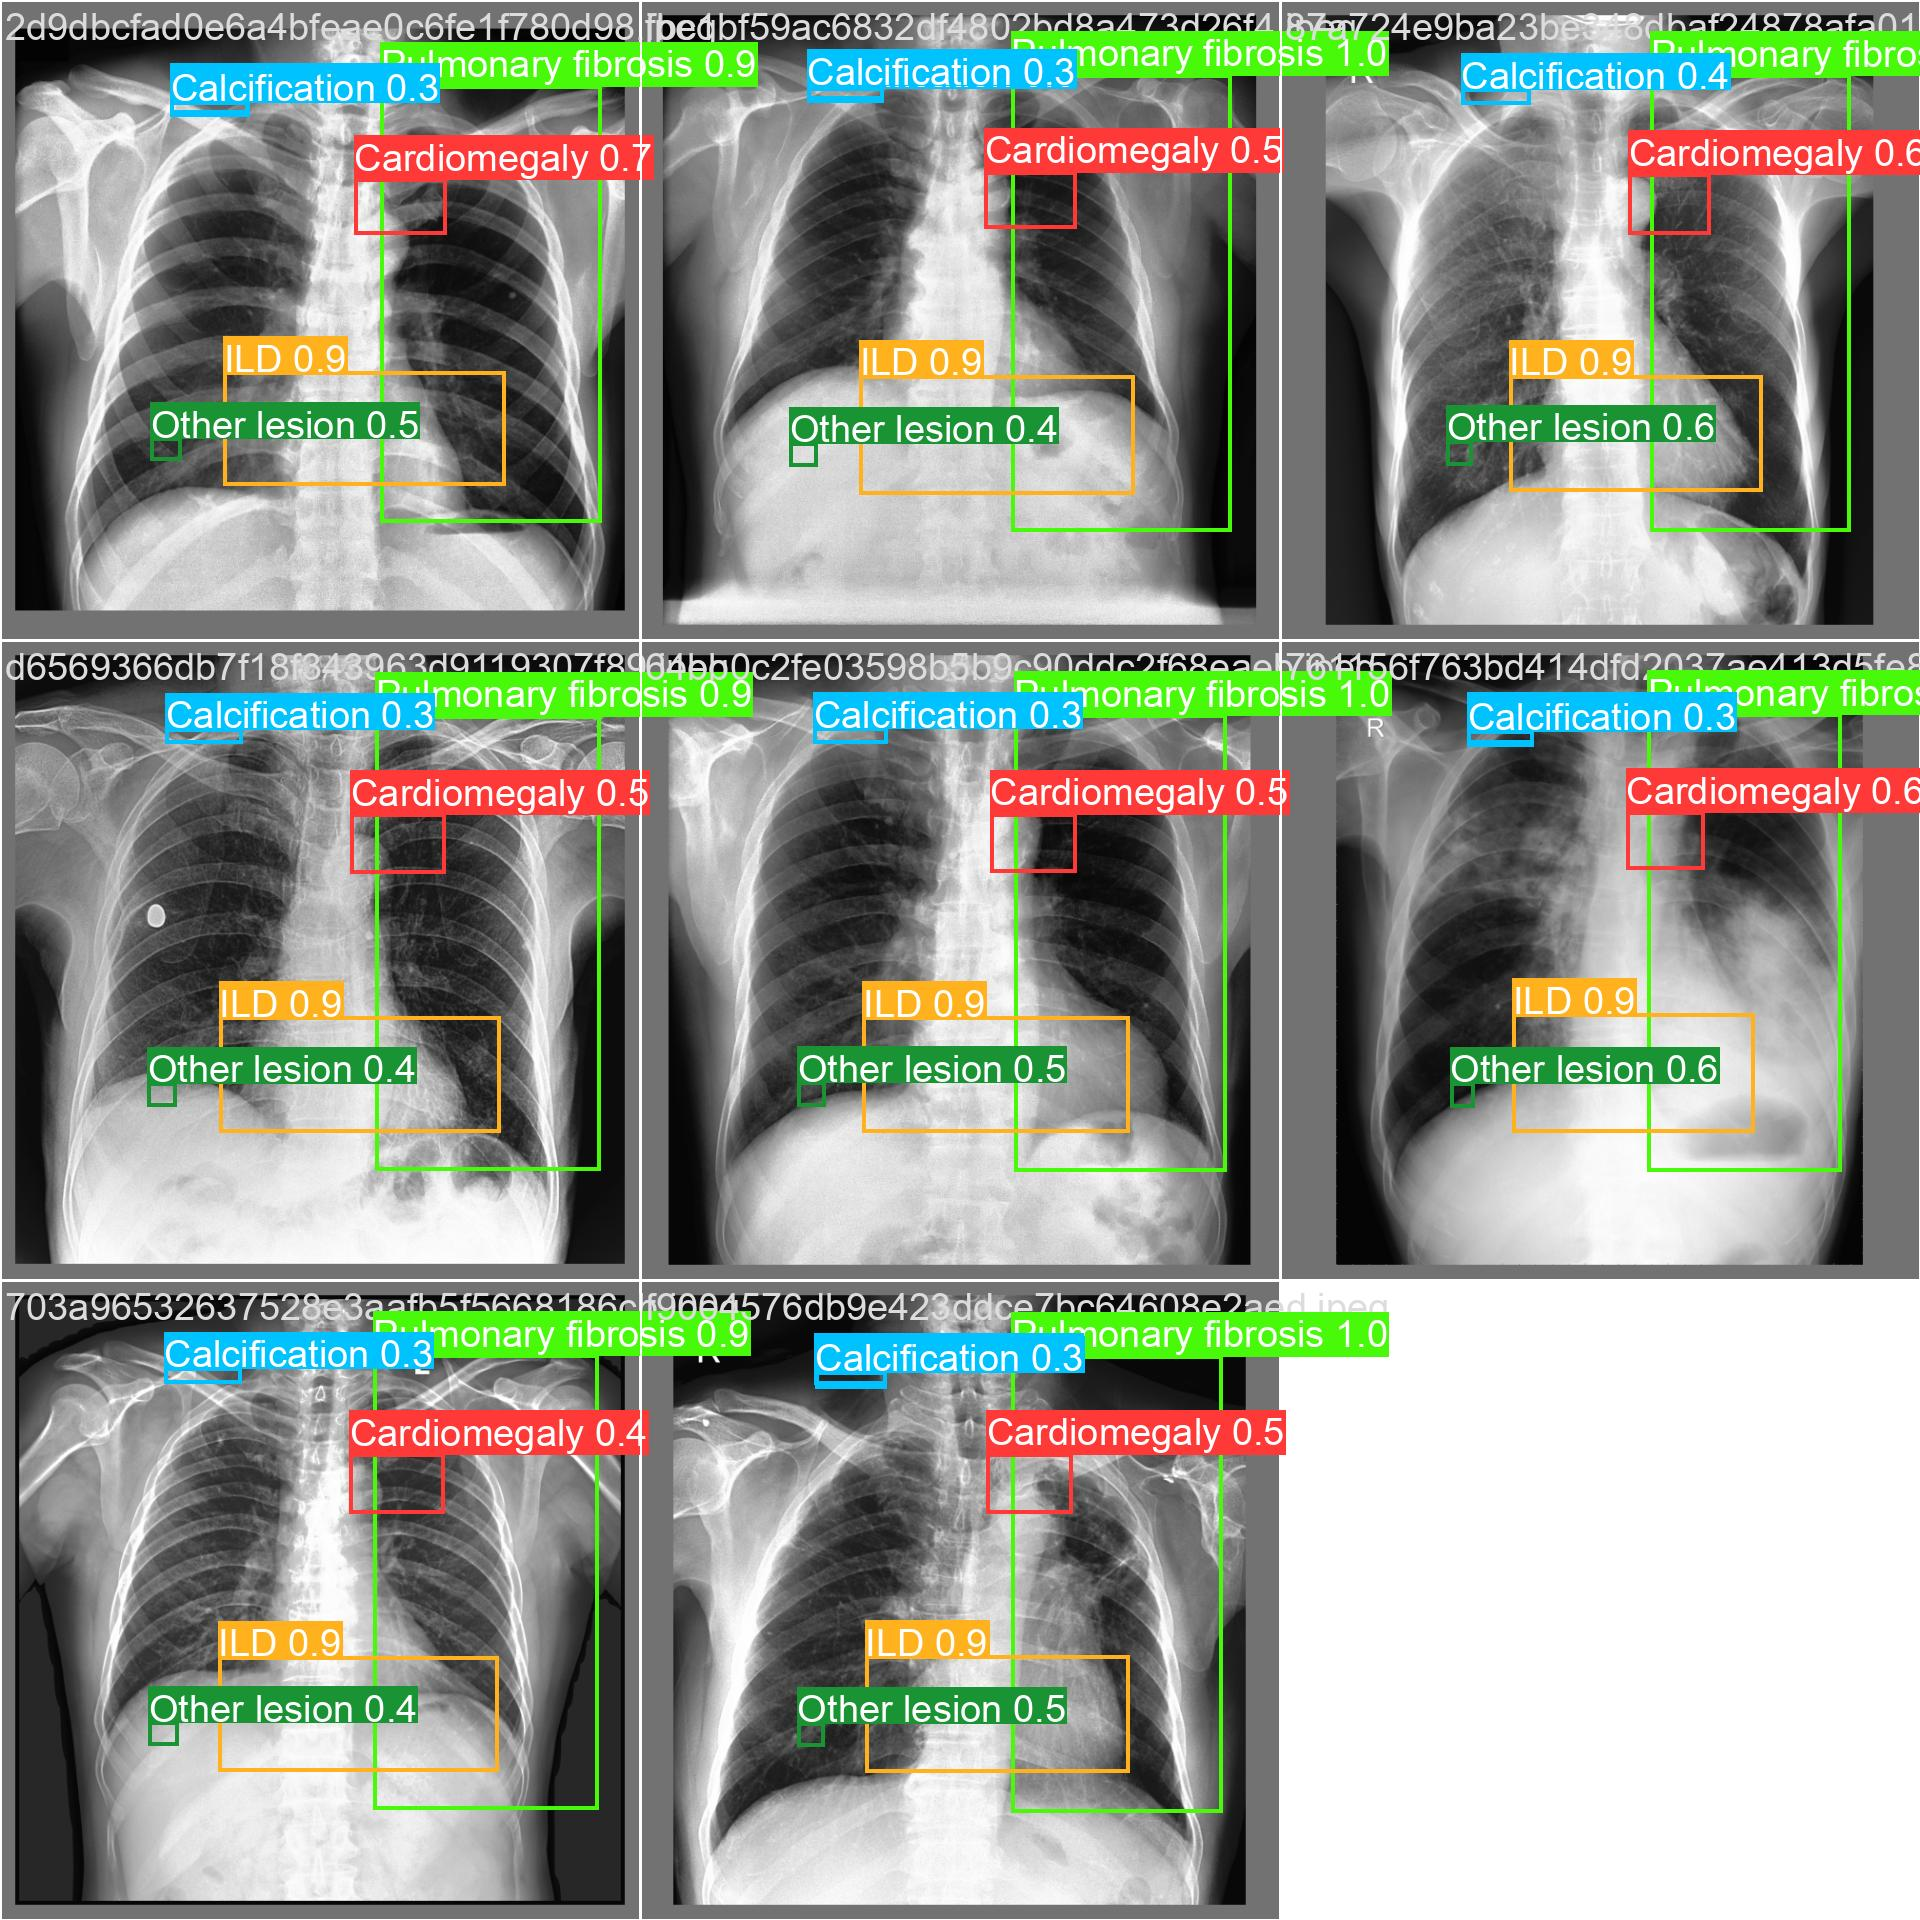

In [55]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/val/exp/val_batch0_pred.jpg", width=700)